In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
data = pd.read_csv('Sorghum_Hyperspectral_Data_1820.csv')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,crop,PlotID,year,trt,pheno,CHL,EWT,LWC,SLA,N,...,X2491,X2492,X2493,X2494,X2495,X2496,X2497,X2498,X2499,X2500
0,sorghum,281,2018,greenhouse,yes,446.944,0.021140,0.801818,191.380472,2.84,...,0.057221,0.057268,0.057137,0.056709,0.056457,0.056115,0.055923,0.055987,0.055888,0.055737
1,sorghum,282,2018,greenhouse,yes,713.800,0.013651,0.718788,187.244828,3.44,...,0.065625,0.065636,0.065593,0.065518,0.065329,0.065109,0.064884,0.064390,0.064180,0.064182
2,sorghum,283,2018,greenhouse,yes,724.911,0.013870,0.715429,181.260442,3.52,...,0.061687,0.061462,0.061244,0.061186,0.060975,0.060398,0.060287,0.060618,0.060535,0.060500
3,sorghum,284,2018,greenhouse,yes,738.400,0.016723,0.753034,182.327753,4.13,...,0.055341,0.055124,0.054997,0.055162,0.055078,0.054760,0.054617,0.054473,0.054353,0.054351
4,sorghum,285,2018,greenhouse,yes,700.344,0.023406,0.798125,168.909288,3.85,...,0.056971,0.057206,0.057154,0.056835,0.056743,0.056700,0.056552,0.056538,0.056412,0.056039


In [4]:
data.year.value_counts(dropna= False)

2020    1470
2018     321
Name: year, dtype: int64

In [5]:
data.shape

(1791, 2171)

In [6]:
data.columns[1:50]

Index(['PlotID', 'year', 'trt', 'pheno', 'CHL', 'EWT', 'LWC', 'SLA', 'N', 'P',
       'K', 'Mg', 'Ca', 'S', 'Fe', 'Mn', 'B', 'Cu', 'Zn', 'X350', 'X351',
       'X352', 'X353', 'X354', 'X355', 'X356', 'X357', 'X358', 'X359', 'X360',
       'X361', 'X362', 'X363', 'X364', 'X365', 'X366', 'X367', 'X368', 'X369',
       'X370', 'X371', 'X372', 'X373', 'X374', 'X375', 'X376', 'X377', 'X378',
       'X379'],
      dtype='object')

In [7]:
data.loc[data.year == 2018 , 'trt'].value_counts(dropna = False)

greenhouse    321
Name: trt, dtype: int64

In [8]:
#define the trait for analysis
trait = 'SLA'


In [9]:
#Drop NAs 
data = data.loc[data[trait].notnull(), :]
#data1 = data[data.SLA.notnull()]
data.shape

(587, 2171)

<AxesSubplot:xlabel='year', ylabel='SLA'>

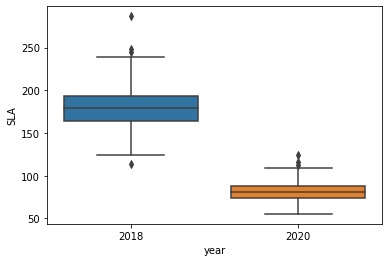

In [10]:
sns.boxplot(y= trait, x='year', data=data)

In [11]:
#defining a function to remove the outliers
def outlier_treatment(datacolumn):
 sorted(datacolumn)
 Q1=datacolumn.quantile(0.25)
 Q3=datacolumn.quantile(0.75)
 #Q1,Q3 = np.percentile(datacolumn , [25,75])
 IQR = Q3 - Q1
 lower_range = Q1 - (1.5 * IQR)
 upper_range = Q3 + (1.5 * IQR)
 return lower_range,upper_range

In [12]:
outlier_treatment(data[trait])


(-67.16692164689113, 329.2306520302035)

In [13]:
lowerbound,upperbound = outlier_treatment(data[trait])

In [14]:
rm_index =data[(data[trait] < lowerbound) | (data[trait] > upperbound)].index
rm_index

Int64Index([], dtype='int64')

In [15]:
data.drop(rm_index, axis=0 ,inplace=True)

In [16]:
# choose the years for grouping in the plots
year = data.loc[: , 'year']

In [17]:
data.shape


(587, 2171)

In [18]:
# define trait data
y = data.loc[: , trait]


In [19]:
#select the columns of HR data
spec_columns = [col for col in data if col.startswith('X')]


In [20]:
# Define the X by choosing only the predictors
X = data[spec_columns]


In [21]:
# Apply Savitzky Golay Filter
X = savgol_filter(X, window_length=5 , polyorder = 2)
X = pd.DataFrame(X, columns= spec_columns)

In [22]:
# Remove first 100 wawelengths
X = X.drop(X.columns[0:100], axis=1)

In [23]:
# Create a np array for downsampling for every 5 nm
column_filter = np.arange(0, 2050, 5)

In [24]:
# Choose from the X based on filtering array
X = X.iloc[: , column_filter]

In [25]:
# split the dataset into training (60%) and testing (40%) sets
X_train,X_test,y_train,y_test = train_test_split(X, y ,test_size=0.4) 

In [26]:
regressor = RandomForestRegressor(2000) #, min_samples_split=5 , min_samples_leaf= 1 , max_features= 'auto' , max_depth =90 , bootstrap = True)
predict = regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [27]:
y_pred = regressor.predict(X_test)

In [28]:
y_pred = pd.DataFrame(y_pred)

In [29]:
# Combine the 'year' and y_test for plotting and reset the index for combining with y_pred
y_test =pd.merge(y_test, year , left_index=True , right_index=True,  how='left').reset_index(drop=True)

In [30]:
y_test.head()

,SLA,year
0,72.250516,2020
1,84.413036,2020
2,191.381579,2018
3,82.217465,2020
4,134.142202,2018


In [31]:
type(y_pred)

pandas.core.frame.DataFrame

In [32]:
#Combine y_test and y_pred and get one data frame for seaborn scatter plot
data_plot = pd.concat([y_test, y_pred], axis = 1)

In [33]:
data_plot =data_plot.rename({0 : 'predicted'} ,axis =1)

In [34]:
data_plot.head()

,SLA,year,predicted
0,72.250516,2020,88.491493
1,84.413036,2020,70.990240
2,191.381579,2018,175.716339
3,82.217465,2020,81.441914
4,134.142202,2018,166.976819


In [35]:
# Calculate the spearman correlation , r2 and p value and pass them into the 'text'

from scipy.stats import pearsonr, spearmanr
#y_pred2 = [x[0] for x in data_plot.predicted]
r, p = spearmanr(data_plot[trait], data_plot.predicted)
r2 = r**2
text =r2, p
text = [np.round(r2, 2) for r2 in text]


Text(0.5, 1.0, 'SLA RF')

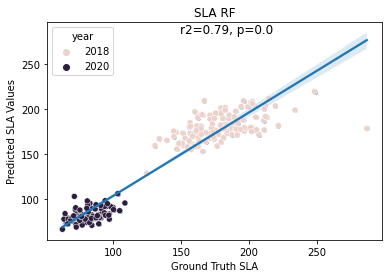

In [36]:
#plot the results
text1 = 'r2=%s, p=%s' % (text[0], text[1])
#sns.lmplot(x=trait, y='predicted',data=data_plot)
sns.regplot(x=trait, y='predicted' , scatter_kws={'s' : 15},data=data_plot)
xmin , xmax , ymin, ymax = plt.axis()
sns.scatterplot(x=trait, y='predicted', hue= 'year', data=data_plot).text((xmax)/2, ymax*0.96, text1, fontsize=12)
plt.xlabel('Ground Truth' + ' ' + trait)
plt.ylabel('Predicted' + ' ' + trait + ' ' + 'Values')
plt.title(trait + ' ' + 'RF')



In [37]:
# Feature Importance
from sklearn.inspection import permutation_importance
result = permutation_importance(regressor, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index = X_train.columns)

In [38]:
forest_importances.sort_values(ascending=False,inplace=True)

In [39]:
most_important = forest_importances[0:200]

In [40]:
most_important = pd.DataFrame(most_important)

In [41]:
most_important

,0
X735,0.143038
X450,0.121083
X740,0.072530
X745,0.050524
X750,0.008052
...,...
X1015,0.000185
X555,0.000184
X520,0.000184
X1270,0.000183


In [42]:
most_important_index = most_important.index

In [43]:
X_reduced = X.loc[: , most_important_index]

In [44]:
# split the dataset into training (60%) and testing (40%) sets
X_train,X_test,y_train,y_test = train_test_split(X_reduced, y ,test_size=0.4) 

In [49]:
regressor = RandomForestRegressor(2000) #, min_samples_split=5 , min_samples_leaf= 1 , max_features= 'auto' , max_depth =90 , bootstrap = True)
predict = regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [50]:
np.sqrt(mean_squared_error(y_test, regressor.predict(X_test)))

18.626202340582104

In [51]:
y_pred = regressor.predict(X_test)

<AxesSubplot:xlabel='SLA', ylabel='Predicted SLA values'>

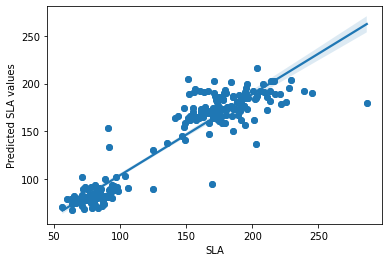

In [52]:
plt.scatter(y_test, y_pred)
plt.ylabel('Predicted' + ' ' + trait +  ' ' 'values')
plt.xlabel('Ground truth LWC measurements')
sns.regplot(x = y_test , y = y_pred)

In [53]:
from scipy.stats import pearsonr, spearmanr

r, p = spearmanr(y_test, y_pred)
r2 = r**2
print(r2, p)

0.7602310668229691 3.3313211588614717e-74


In [ ]:
data_2022 = pd.read_csv('sorghum_2022_whole.csv')

In [ ]:
data_2022 =data_2022.loc[data_2022['355'].notnull(), :]

In [ ]:
data_2022['CHL'] = data_2022[['CHLp1', 'CHLp2']].mean(axis=1)

In [ ]:
#data_2022 = data_2022.loc[data_2022['Leaf_num'] == 2 , :]

In [ ]:
#data_2022 = data_2022.loc[data_2022['Leaf_pos'] == 2 , :]

In [ ]:
data_2022 = data_2022.loc[data_2022['355']>0 , :]
data_2022.head()

In [ ]:
import copy
data_test = copy.deepcopy(data_2022)


my_group = data_test.groupby(['Genotype', 'Rep', 'Leaf_num']).mean()

my_group.head()

In [ ]:
my_group = my_group.reset_index(level=['Leaf_num', 'Genotype', 'Rep'])
my_group.head() 

In [ ]:
my_group.columns

In [ ]:
sns.set(style='darkgrid')
sns.displot(data= my_group, x = 'DW').set(xlabel = 'Dry Mass')


In [ ]:
y_test = my_group.loc[:,trait]

In [ ]:
X_total = my_group.iloc[:, 13:2164]

In [ ]:
X_total.drop(columns = X_total.columns[0:100], inplace = True) 

In [ ]:
X_total

In [ ]:
column_filter = np.arange(0,2050,5)  ## creating an index for column filtering
X_test= X_total.iloc[:, column_filter] # selecting the filtered columns 

## Hyperparameter Grid Search

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

## Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = RepeatedKFold(n_splits=10), verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

rf_random.best_params_

In [ ]:
regressor = RandomForestRegressor(2000)#, min_samples_split=5 , min_samples_leaf= 2 , max_features= 'auto' , max_depth =90 , bootstrap = True)
predict = regressor.fit(X, y)
y_pred = regressor.predict(X_test)

In [ ]:
np.sqrt(mean_squared_error(y_test, regressor.predict(X_test)))

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
plt.scatter(y_test, y_pred)
plt.ylabel('Predicted CHL values')
plt.xlabel('Ground truth SLA measurements')
sns.regplot(x = y_test , y = y_pred)


In [ ]:
from scipy.stats import pearsonr, spearmanr

r, p = spearmanr(y_test, y_pred)
r2 = r**2
print(r2, p)